# Classify if image contains road sign

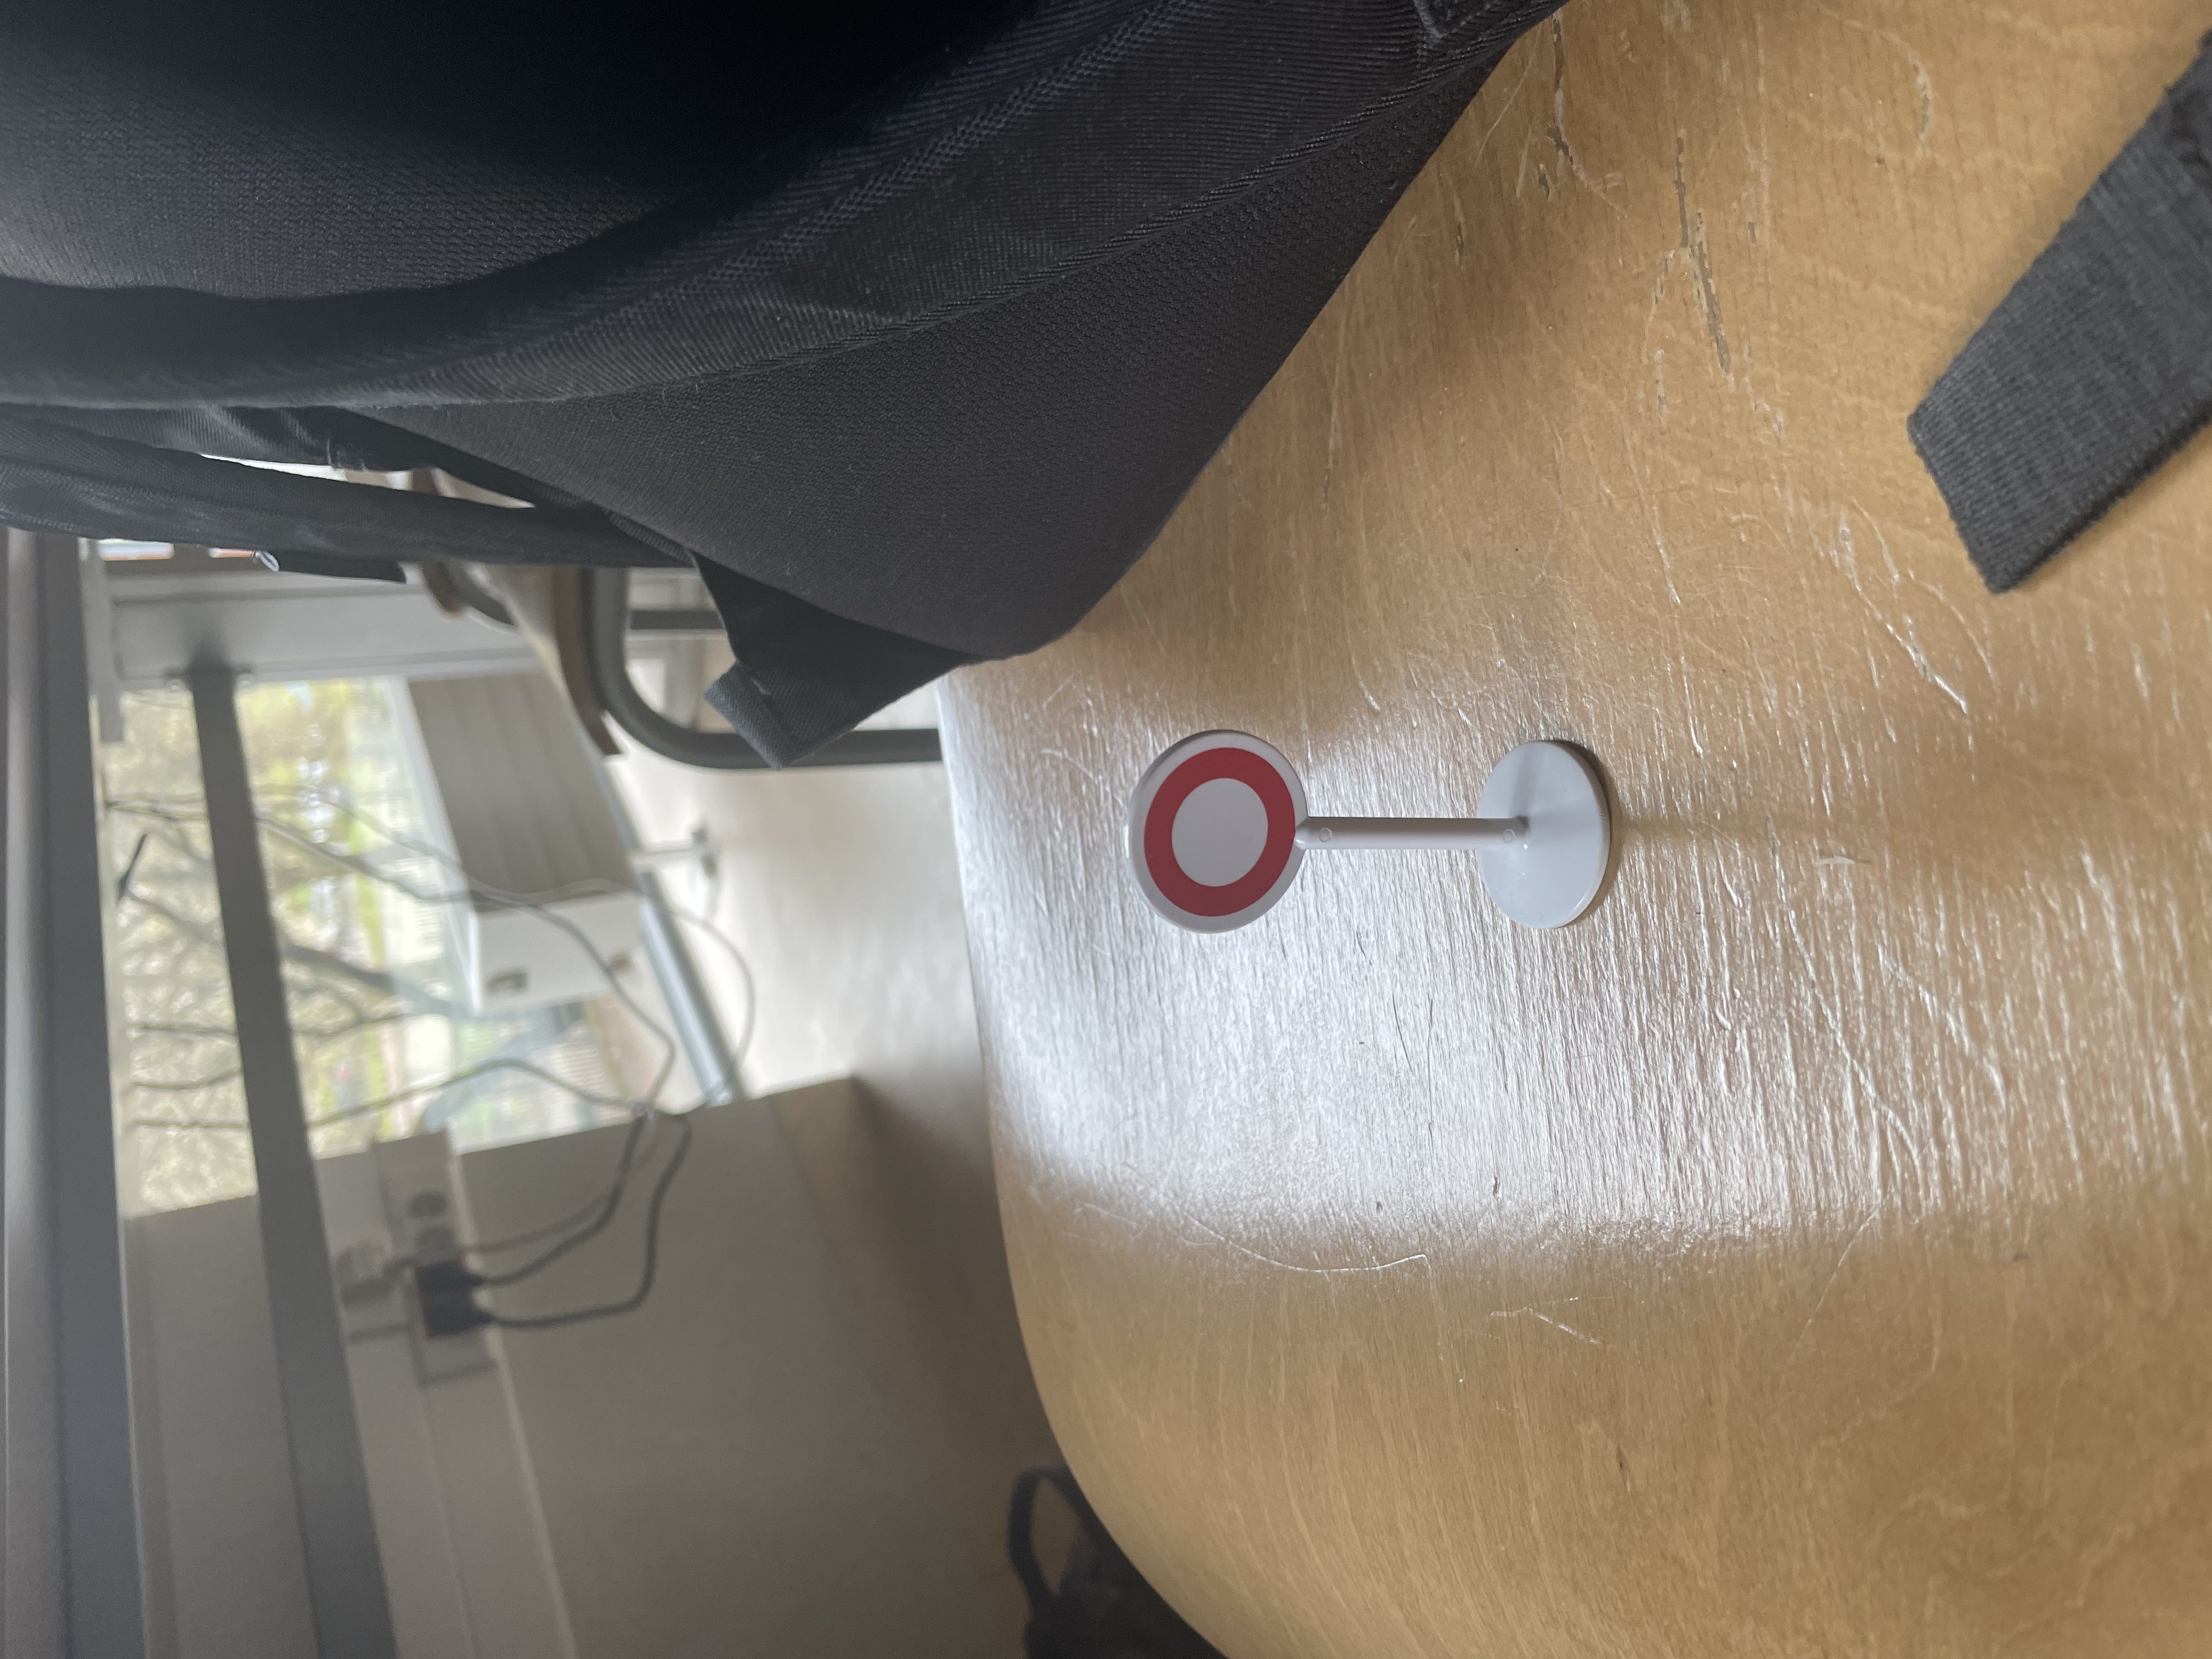

In [1]:
from IPython.display import Image
Image(filename='data/road_sign/IMG_3918.jpg', width=500) 

## Imports Packages

In [2]:
# imports

# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle
import json

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image


2023-12-31 18:18:47.068942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-31 18:18:47.184425: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-31 18:18:47.184443: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-31 18:18:47.709505: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

tf.__version__: 2.11.0
keras.__version__: 2.11.0


## Load Train Data

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ['data/road_sign/IMG_3900.jpg', 'data/road_sign/IMG_3901.jpg', 'data/road_sign/IMG_3902.jpg', 'data/road_sign/IMG_3903.jpg', 'data/road_sign/IMG_3906.jpg', 'data/road_sign/IMG_3907.jpg', 'data/road_sign/IMG_3909.jpg', 'data/road_sign/IMG_3911.jpg', 'data/road_sign/IMG_3912.jpg', 'data/road_sign/IMG_3913.jpg', 'data/road_sign/IMG_3914.jpg', 'data/road_sign/IMG_3915.jpg', 'data/road_sign/IMG_3916.jpg', 'data/road_sign/IMG_3918.jpg', 'data/road_sign/IMG_3919.jpg', 'data/road_sign/IMG_3920.jpg', 'data/road_sign/IMG_3921.jpg', 'data/road_sign/IMG_3922.jpg', 'data/road_sign/IMG_3924.jpg', 'data/road_sign/IMG_3926.jpg', 'data/road_sign/IMG_3928.jpg', 'data/road_sign/IMG_3929.jpg', 'data/road_sign/IMG_3930.jpg', 'data/road_sign/IMG_3931.jpg', 'data/road_sign/IMG_3932.jpg', 'data/road_sign/IMG_3933.jpg', 'data/road_sign/IMG_3934.jpg', 'data/road_sign/IMG_3935.jpg', 'data/road_sign/IMG_3938.jpg

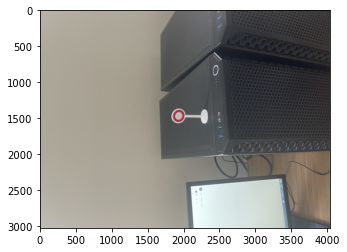

In [3]:
# import data
image_paths = []
commands = []
data_dir = 'data/road_sign/'
model_output_dir = '../model'

file = open(os.path.join(data_dir, 'sequences.json'))
sequence = json.load(file)
for step in sequence['sequence']:
    image_paths.append(data_dir + step['photo'])
    commands.append(step['action'])

print(commands, image_paths)    


image_index = 1
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("command: %d" % commands[image_index] )
df = pd.DataFrame()
df['image_path'] = image_paths
df['command'] = commands

(array([16.0000, 18.0000]),
 array([0.0000, 0.5000, 1.0000]),
 <BarContainer object of 2 artists>)

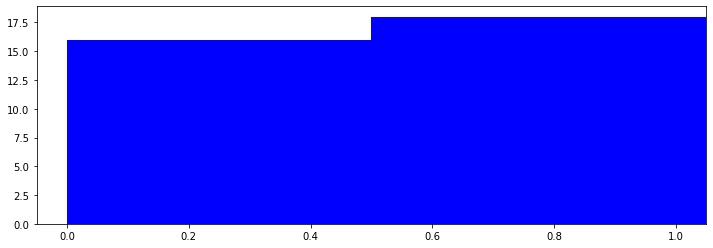

In [4]:
# Look at the distribution of commands
# distribution has to be balanced
num_of_bins = 2

hist, bins = np.histogram(df['command'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['command'], bins=num_of_bins, width=1, color='blue')

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, commands, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))


Training data: 27
Validation data: 7


## Image Augumentation
Since we only have a few hundred images, to train a deep network, we need a lot more images.   Instead of running our car, let's try to augment our data. There are a couple of ways to do that.

1. Zoom: crop out a smaller image from the center
1. Pan: crop out a smaller image from left or right side
1. adjust brightness of the image
1. flip the image horizontally, i.e do a left to right flip, and change the steering angle coorespondingly
1. introduce an Gaussian blur

We can combine the above augmentation techniques to generate 100s times of the training images, with just a few hundred real images.



Text(0.5, 1.0, 'zoomed')

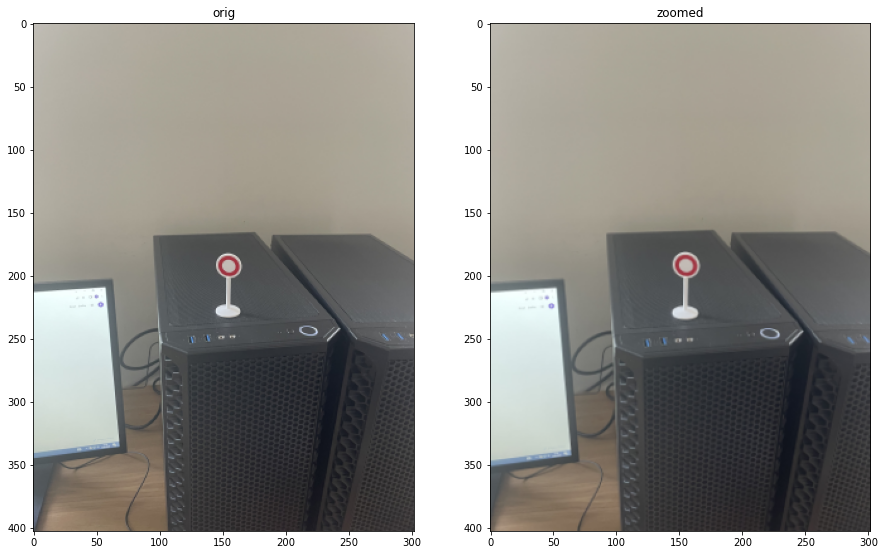

In [6]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    scale_percent = 10 # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_zoom)
axes[1].set_title("zoomed")


Text(0.5, 1.0, 'panned')

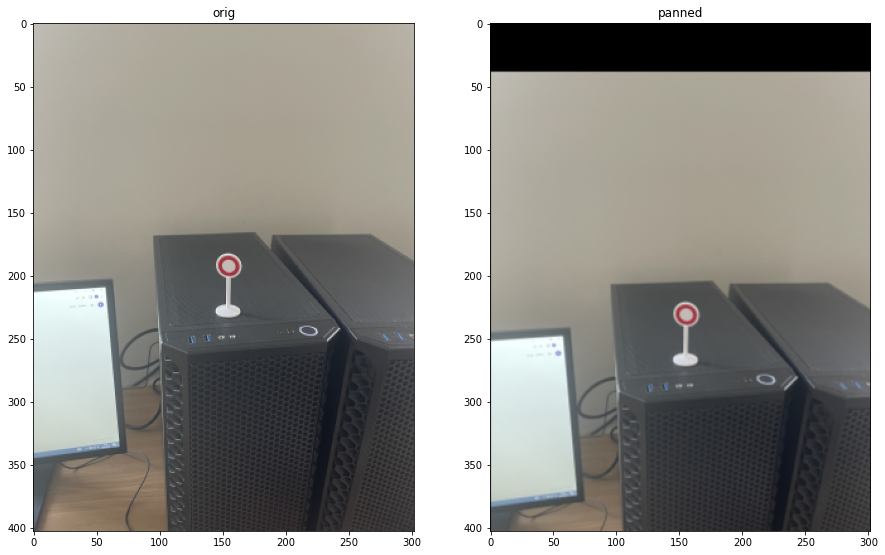

In [7]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_pan = pan(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_pan)
axes[1].set_title("panned")


Text(0.5, 1.0, 'brightness adjusted')

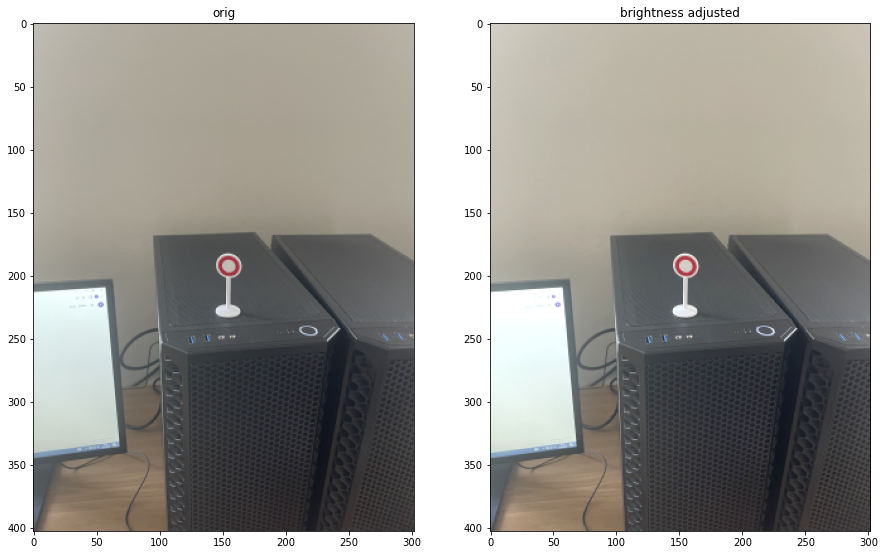

In [8]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_brightness = adjust_brightness(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_brightness)
axes[1].set_title("brightness adjusted")

Text(0.5, 1.0, 'blurred')

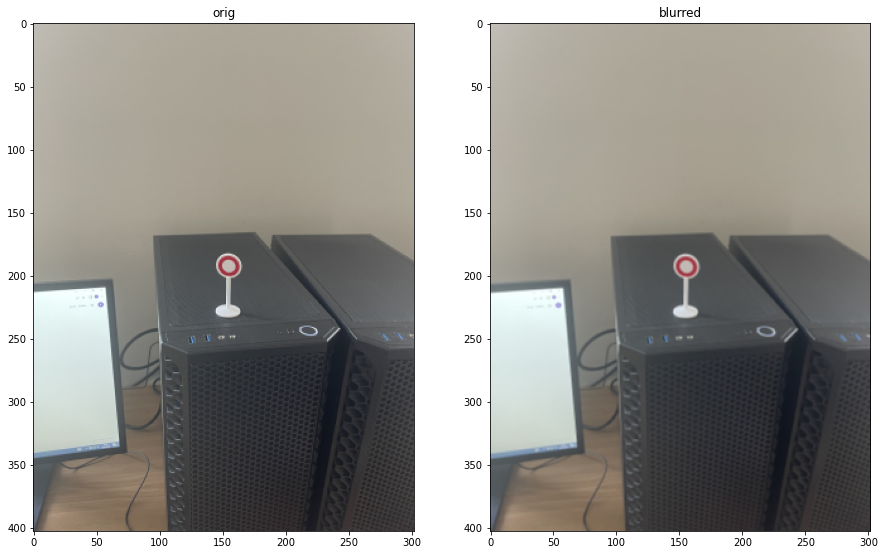

In [9]:
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_blur = blur(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_blur)
axes[1].set_title("blurred")

Text(0.5, 1.0, 'flipped, original=0')

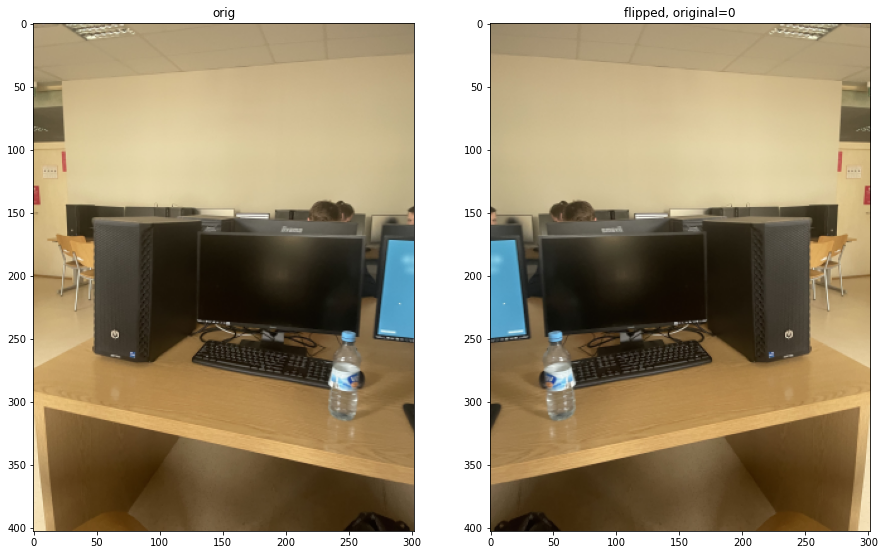

In [10]:
def random_flip(image):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
   
    return image

image_index = 20
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_flip = random_flip(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_flip)
axes[1].set_title("flipped, original=%s" % (commands[image_index]))

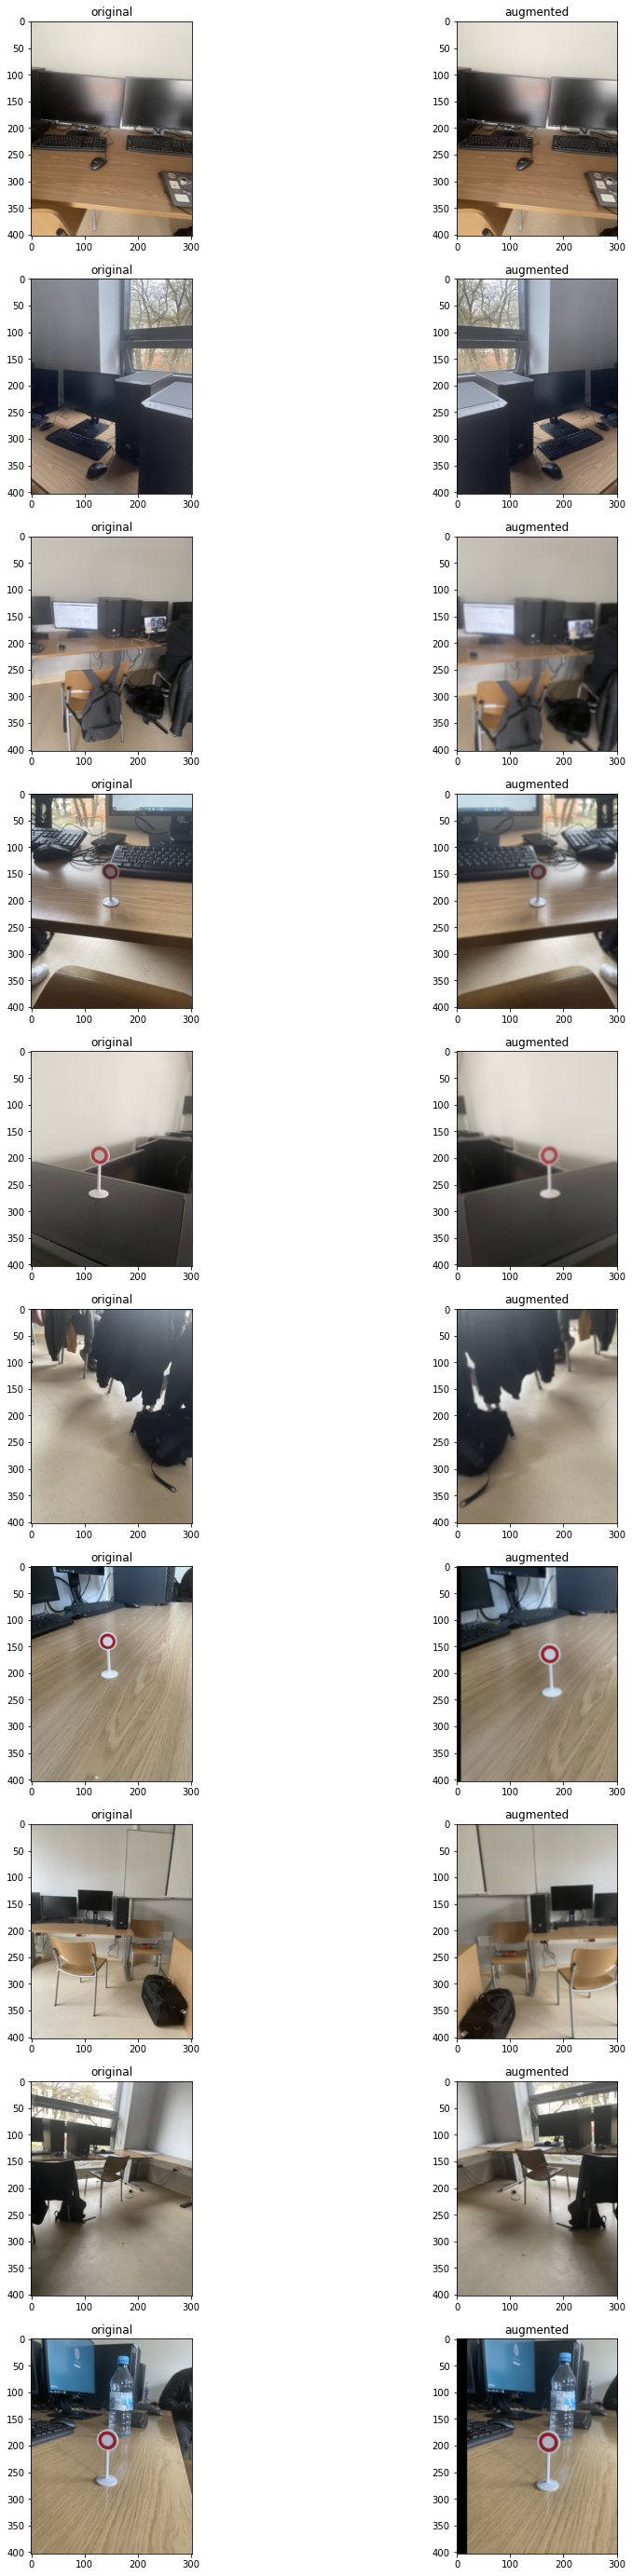

In [11]:
# put it together
def random_augment(image):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image = random_flip(image)
    
    return image

# show a few randomly augmented images
ncol = 2
nrow = 10
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
    rand_index = random.randint(0, len(image_paths) - 1)
    image_path = image_paths[rand_index]
    
    image_orig = my_imread(image_path)
    image_aug = random_augment(image_orig)
    
    axes[i][0].imshow(image_orig)
    axes[i][0].set_title("original")
    axes[i][1].imshow(image_aug)
    axes[i][1].set_title("augmented")
    

## Preprocess Training Data for Nvidia Model

Text(0.5, 1.0, 'processed')

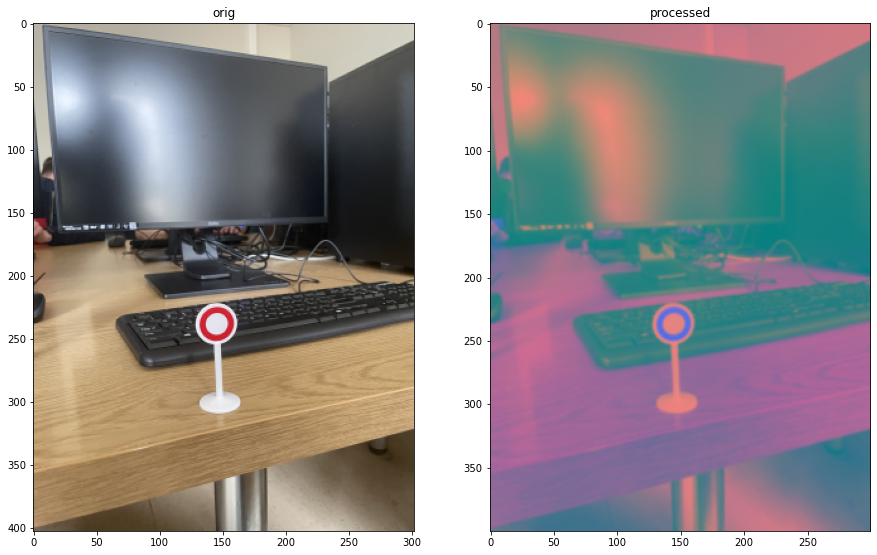

In [12]:
image_index = 17
def img_preprocess(image):
    height, _, _ = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (300,400)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")


## Create and Train Model

In [13]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(300, 400, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(lr=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [14]:
model = nvidia_model()
print(model.summary())
# check at we will have 252,219 trainable parameters

Model: "Nvidia_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 198, 24)      1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 97, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 47, 48)        43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 45, 64)        27712     
                                                                 
 dropout (Dropout)           (None, 32, 45, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 43, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 82560)            

2023-12-31 18:18:58.043561: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/michal/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-12-31 18:18:58.043584: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-31 18:18:58.043604: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (michal-ThinkPad-E14-Gen-3): /proc/driver/nvidia/version does not exist
2023-12-31 18:18:58.043805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the 

In [15]:
def image_data_generator(image_paths, commands, batch_size, is_training):
    while True:
        batch_images = []
        batch_commands = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            command = commands[random_index]
            if is_training:
                # training: augment image
                image = random_augment(image)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_commands.append(command)
            
        yield( np.asarray(batch_images), np.asarray(batch_commands))
            
            

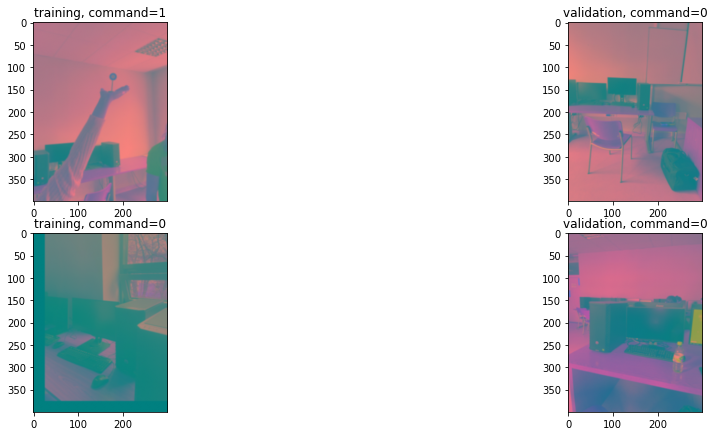

In [16]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, command=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, command=%s" % y_valid_batch[i])


In [17]:
# start Tensorboard before model fit, so we can see the epoch tick in Tensorboard
# Jupyter Notebook embedded Tensorboard is a new feature in TF 2.0!!  

# clean up log folder for tensorboard
log_dir_root = f'{model_output_dir}/logs/'
#!rm -rf $log_dir_root


In [ ]:
# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'road_sign_classifier_check_v2.h5'), verbose=1, save_best_only=True)

print("road sign classifier train started")
history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=300,
                              epochs=20,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'road_sign_classifier_final_v2.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    
print("road sign classifier train finished. val_loss from %.1f to %.1f" % (history.history['val_loss'][0], history.history['val_loss'][-1]))


road sign classifier train started


/tmp/ipykernel_407814/1257241324.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100, is_training=True),


Epoch 1/20
  2/300 [..............................] - ETA: 2:26:34 - loss: 7.7204

## Check Trained Model on Validation Data

In [ ]:
history.history


In [ ]:
# plot training and validation losses
# this should be the same as tensorboard
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

In [ ]:
history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/road_sign_classifier_check_v2.h5')
    Y_pred2 = []
    Y_pred = model.predict(X)
    for y in Y_pred:
        Y_pred2.append(y)
    summarize_prediction(Y, Y_pred2)
    for y in zip(Y, Y_pred):
        print(y)
    return Y_pred

In [ ]:
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual command={y_test[i]}, predicted command={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")


In [ ]:
def imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

model = load_model(f'{model_output_dir}/road_sign_classifier_check_v2.h5')
X = np.array([
    img_preprocess(imread('sequences/sequence_3/2022-11-29 09:30:13.755945.jpg')),
    img_preprocess(imread('sequences/sequence_5/2022-11-29 09:31:52.166020.jpg')),
    img_preprocess(imread('sequences/sequence_5/2022-11-29 09:31:59.492469.jpg'))
])
print(X_test.shape)
print(np.array([X]).shape)
Y_pred = model.predict([X])
Y_pred

As we can see the $R^2$ of the predicted was around 95% and Mean Squared Errors (MSE) are low, indicating the model is predicting a steering angle every simliar to our hand coded land follower, which was used as the model input. 

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(f'{model_output_dir}model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
from threading import Thread
from time import sleep

def listen_command(command):
    while command[0] != 'x':
#         put here contant of drive loop
        sleep(.5)

command = ['o']
t = Thread(target=modify_variable, args=(var, ))
t.start()

# listen for break command in main thread
while command[0] != 'x':
    print(command[0])
    command[0] = input()
    sleep(.5)
    
t.join()


In [ ]:
from sknn.mlp import Classifier, Convolution, Layer, Native
from lasagne import layers as lasagne, nonlinearities as nl



def nvidia_model_sklearn():
    model = Classifier(
    layers=[
        Native(lasagne.DenseLayer, num_units=256, nonlinearity=nl.leaky_rectify),
        Convolution("Rectifier", channels=8, kernel_shape=(3,3)),
        Layer("Softmax")],
    learning_rate=0.02,
    n_iter=5)
    
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(lr=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model    
    